#  Getting started with PyMC3

-- Reza Rashetnia

## Introduction

Probabilistic Programming allows to define probabilistic models and develope Bayesian inferences. PyMC3 is a new open source Probabilistic Programming framework written in Python. Providing recent advances in Markov chain Monte Carlo (MCMC) sampling, PyMC3 allows inference on increasingly complex models.  PyMC3 features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don’t need to have specialized knowledge about how the algorithms work. PyMC3, Stan (Stan Development Team, 2014), and the LaplacesDemon package for R are currently the only PP packages to offer HMC. Here, we present a primer on the use of PyMC3 for solving general Bayesian statistical inference and prediction problems. 

* Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

* Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

* Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0. http://mc-stan.org.

## Example I: Linear Regression

First example is a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes 𝑌 as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_{1}$ and $X_{2}$.

$$Y \sim N(\mu,\sigma^{2})$$

$$\mu = \alpha + \beta_{1}*X_{1} + \beta_{2}*X_{2}$$


where 𝛼 is the intercept, and 𝛽𝑖 is the coefficient for covariate 𝑋𝑖, while 𝜎 represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to weak information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for 𝜎.

$$\alpha \sim N(0,100)$$

$$\beta_{i} \sim N(0,100)$$

$$\sigma \sim N(0,1)$$

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

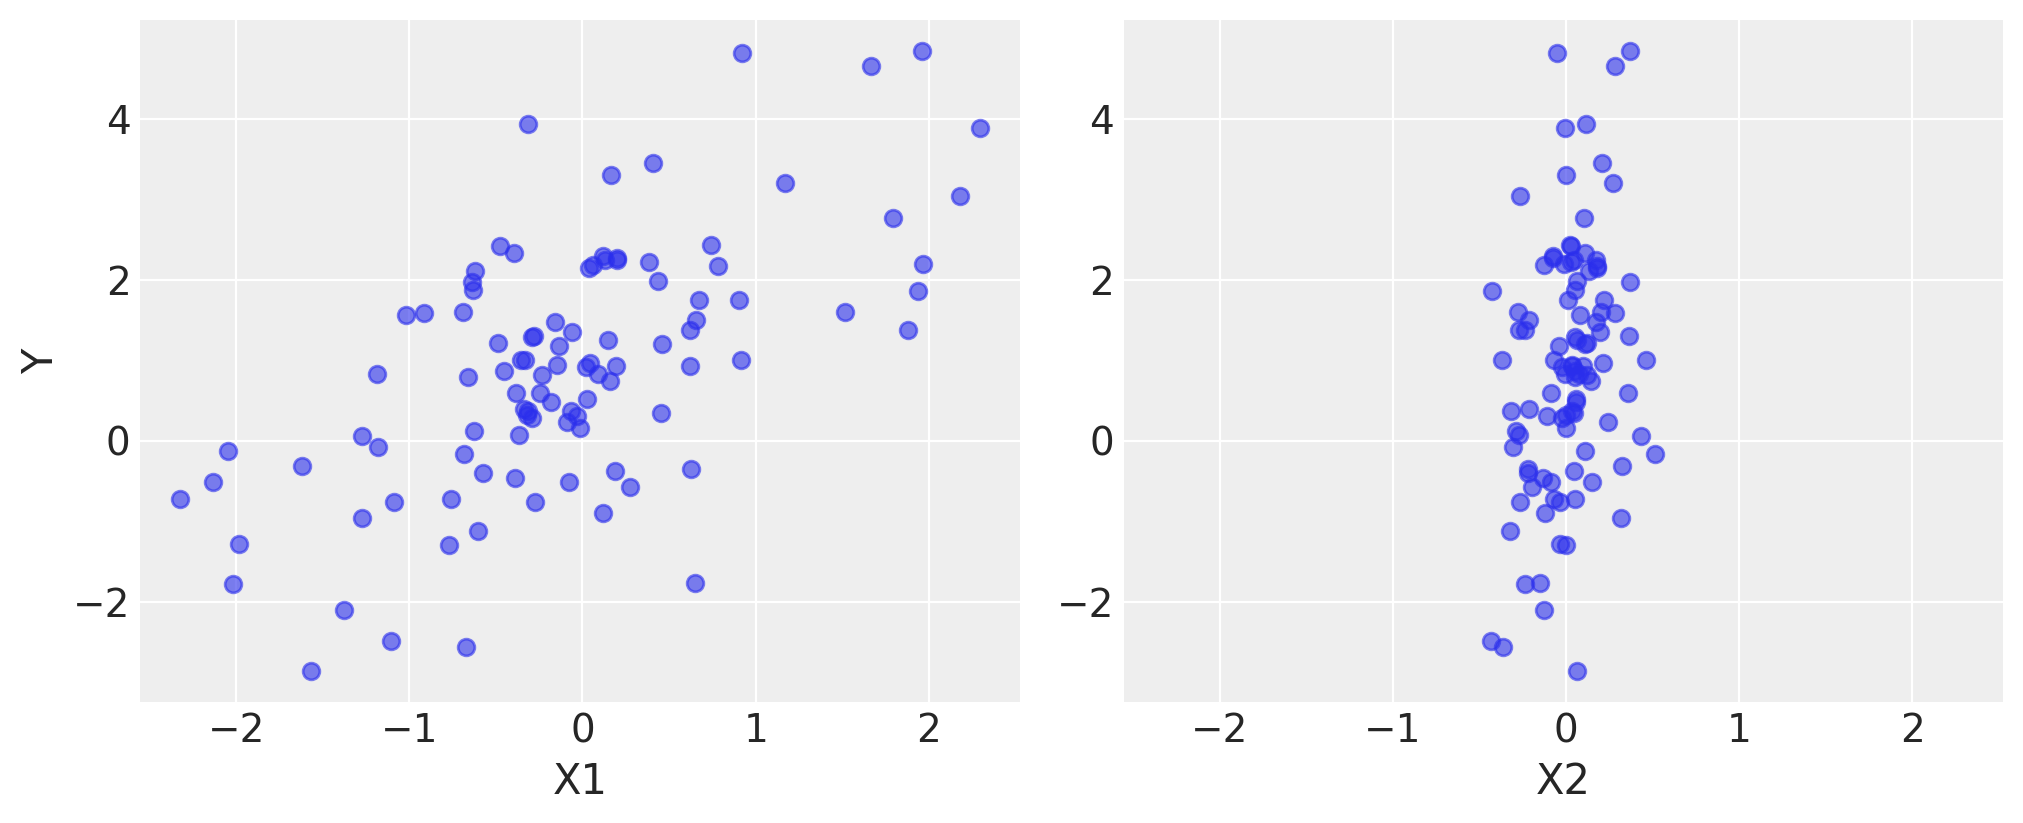

In [2]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [3]:
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [23]:
basic_model = pm.Model()                    # creates a new Model object which is a container for the model random variables.

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)       # stochastic random variables
    beta1 = pm.Normal("beta1", mu=0, sigma=10)# stochastic random variables
    beta2 = pm.Normal("beta2", mu=0, sigma=10)# stochastic random variables
    # The shape argument is available for all distributions and specifies the length or shape of the random variable
    sigma = pm.HalfNormal("sigma", sigma=1)          # stochastic random variables
    # These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, 
    # which for priors are simple constants, and partly random (or stochastic).
    
    # Expected value of outcome
    mu = alpha + beta1 * X1 + beta2 * X2    # deterministic random variable

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)    # observed stochastic

### Fitting the model: posterior estimation
Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: 

1. finding the maximum a posteriori (MAP) point using optimization methods

2. Sampling the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods

### 1. Maximum a posteriori methods

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

In [24]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta1': array(1.10071814),
 'beta2': array(2.9511438),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module. For example, below we use Powell’s method to find the MAP.

In [25]:
map_estimate = pm.find_MAP(model=basic_model, method="powell")
map_estimate

/usr/local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


{'alpha': array(0.9578555),
 'beta1': array(1.10210411),
 'beta2': array(2.95512283),
 'sigma_log__': array(0.03630778),
 'sigma': array(1.03697496)}

* Note that the MAP estimate is not always reasonable.This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together.

* Most techniques for finding the MAP estimate also only find a local optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

* In summary, while PyMC3 provides the function find_MAP(), at this point mostly for historical reasons, this function is of little use in most scenarios. If you want a point estimate you should get it from the posterior. In the next section we will see how to get a posterior using sampling methods.

Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the true posterior distribution.

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

* Binary variables will be assigned to BinaryMetropolis
* Discrete variables will be assigned to Metropolis
* Continuous variables will be assigned to NUTS

Auto-assignment can be overriden for any subset of variables by specifying them manually prior to sampling.

Gradient-based sampling methods

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3’s most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables.

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

PyMC3 automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points. Also, PyMC3 will automatically assign an appropriate sampler if we don’t supply it via the step keyword argument (see below for an example of how to explicitly assign step methods).

In [26]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta2, beta1, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 11 seconds.


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a Trace object containing the samples collected, in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the alpha variable as follows:

In [27]:
trace["alpha"][-5:]

array([1.02853787, 0.91194337, 1.06330288, 0.85255755, 0.77168994])

In [28]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta2]
>Slice: [beta1]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


# Posterior analysis

PyMC3’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named ArviZ. A simple posterior plot can be created using plot_trace.

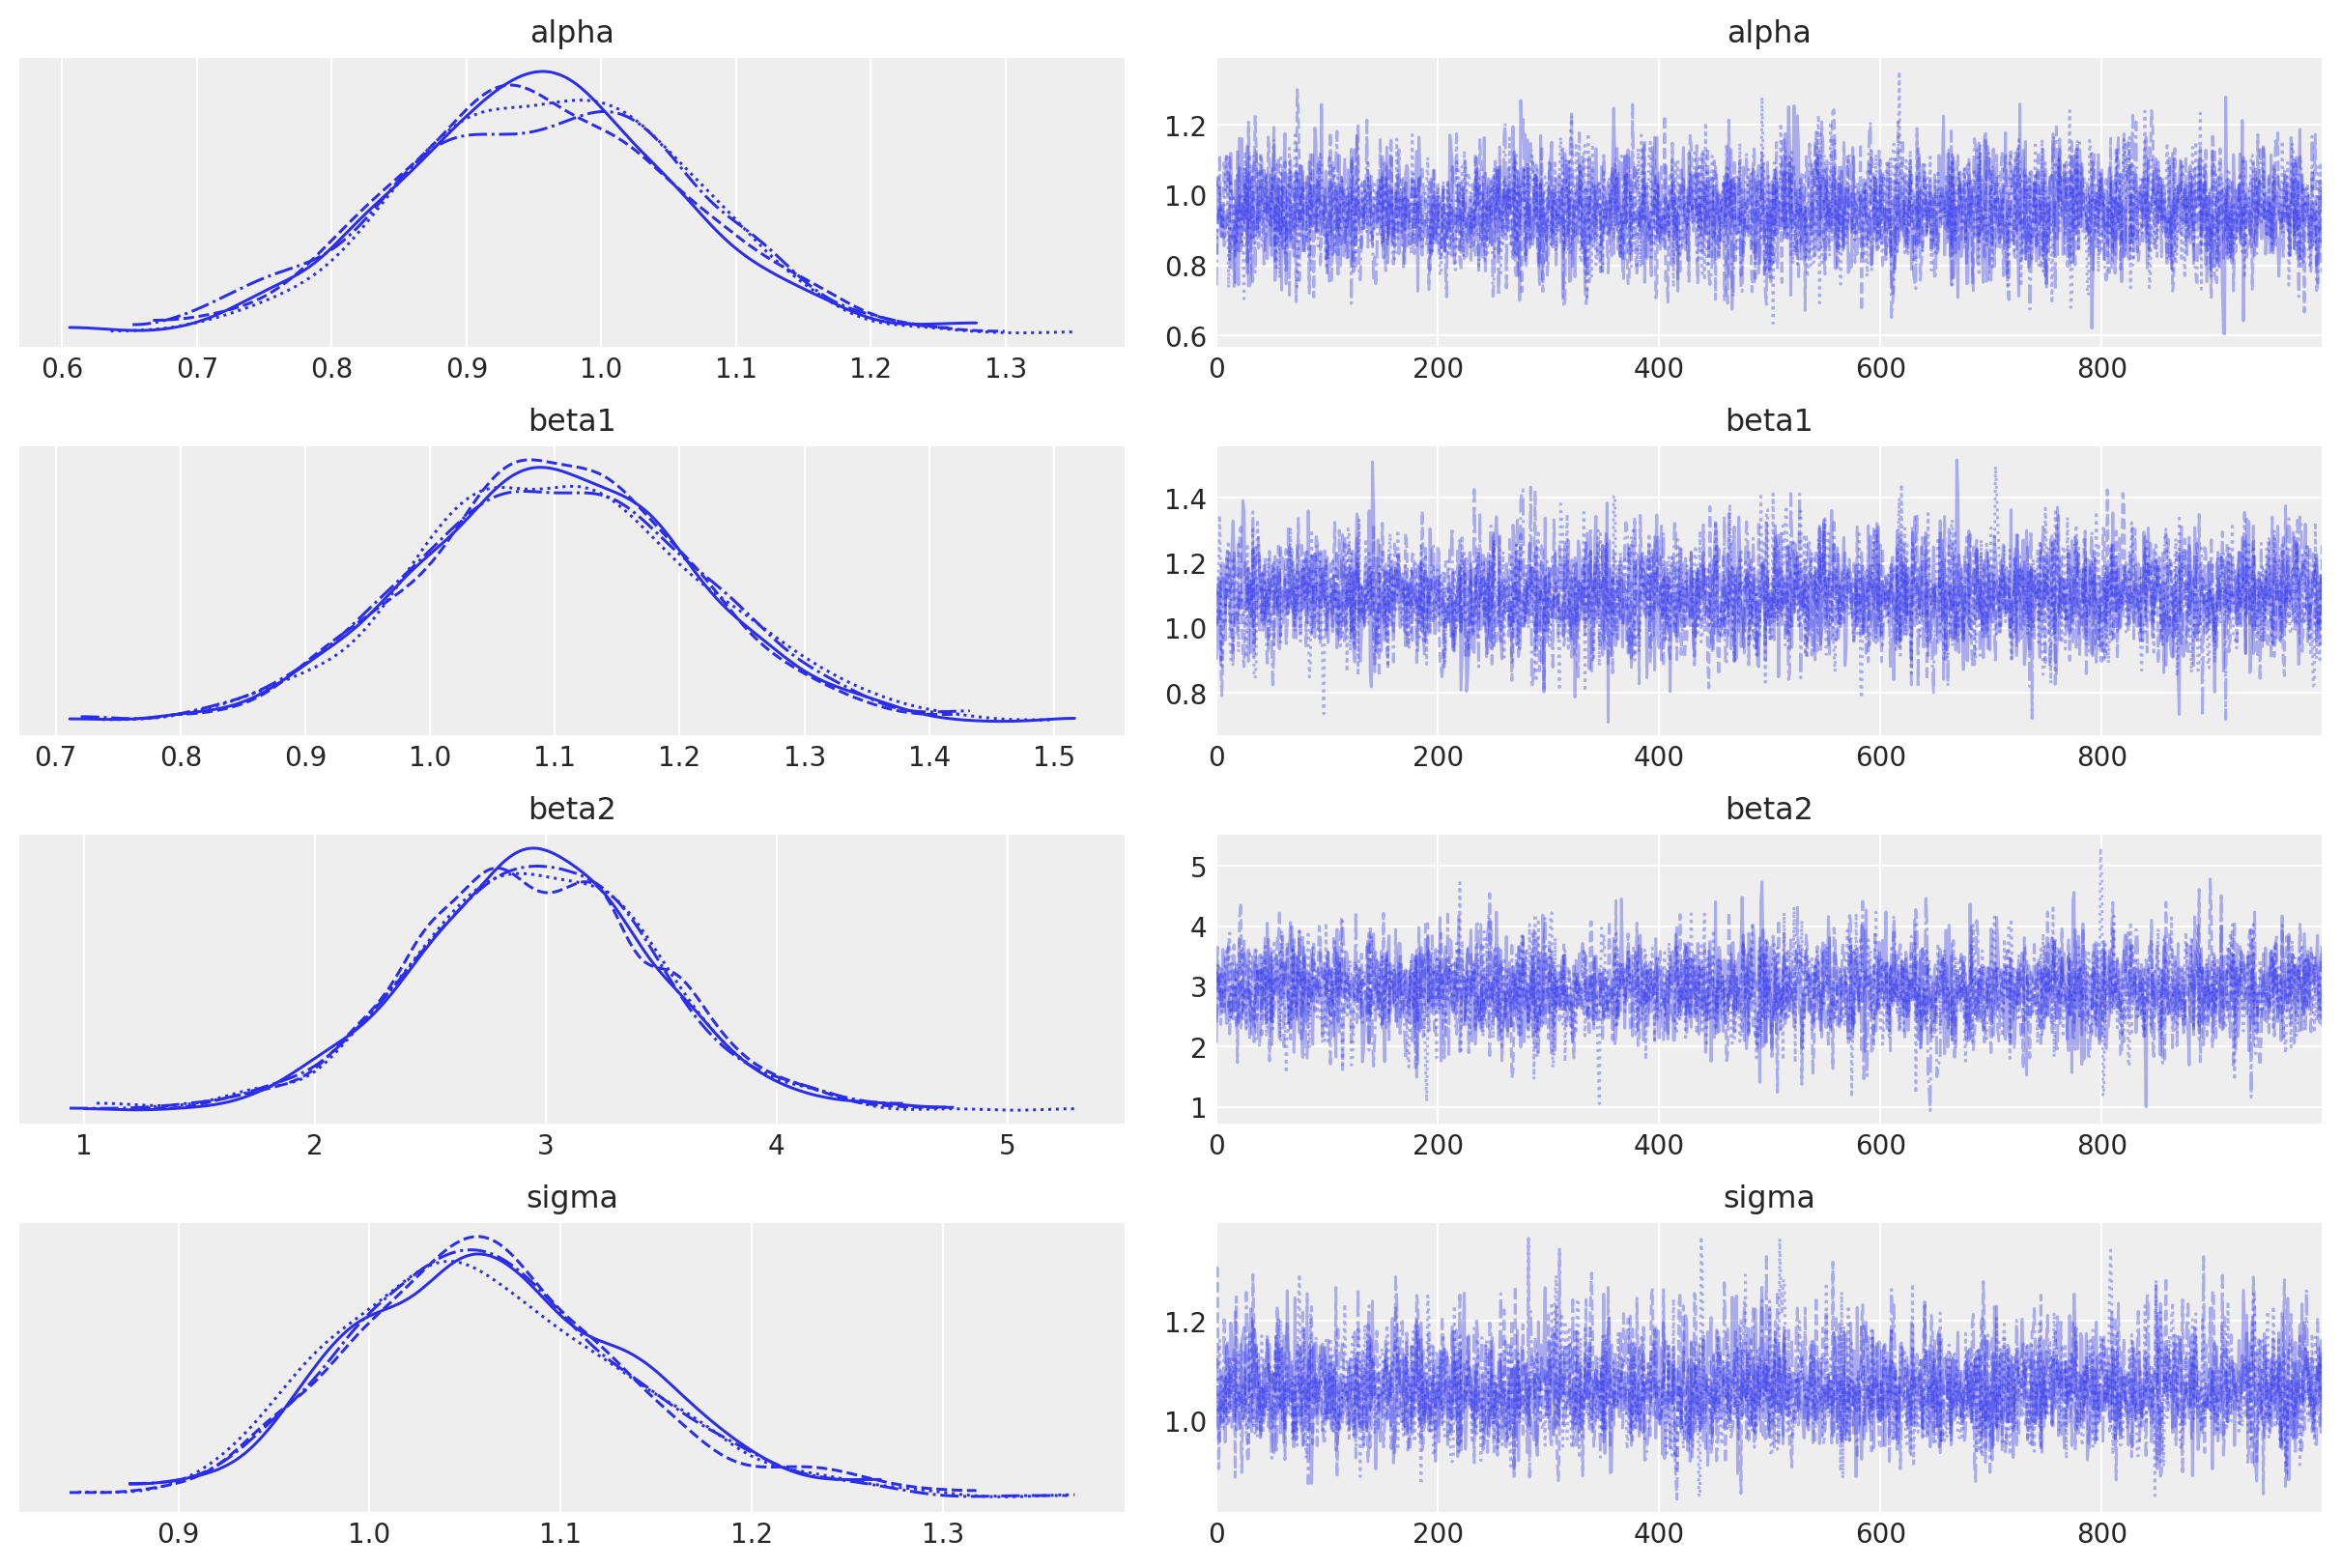

In [29]:
with basic_model:
    az.plot_trace(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [31]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.96,0.11,0.74,1.14,0.00,0.00,3978.17,2884.31,1.0
beta1,1.10,0.11,0.89,1.31,0.00,0.00,3848.92,3117.03,1.0
beta2,2.95,0.53,1.95,3.94,0.01,0.01,3952.09,3038.26,1.0
sigma,1.06,0.08,0.92,1.21,0.00,0.00,3743.19,3003.59,1.0


## Example II: Stochastic volatility of TSLA

Probabilistic Programming are main tools for stock and financial forecasting. In this example, I aim to study the stochastic volatility of Tesla stock (TSLA). Generally, the distribution of market returns is highly non-gaussian. This specificaly makes sampling of the volatilities more difficult. Using PyMC3 is very helpful in these sorts of problems due to it's more advanced MCMC tecniques. Here, this example has 500+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Here, we use NUTS, which is dramatically more efficient.

Any asset prices have variance of day over day returns which is time-varying volatility. Sometimes, returns are highly volatile while in others are more stable. Here, stochastic volatility model assess this with a latent volatility variable, which changes over time. I chose TSLA for this example specifically due to it's high volatility. I have used the model similar to the NUTS paper (Hoffman 2014, p. 21):

$$v \sim \exp(0.1)$$

$$\sigma \sim \exp(50)$$

$$s_{i} \sim N(s_{i-1},\sigma^{2})$$

$$\log(r_{i}) \sim t(v,0,\exp(-2s_{i}))$$

Here, $r$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_{i}$ are the individual daily log volatilities in the latent log volatility process.

In [79]:
# Data
import pandas as pd

df = pd.read_csv("TSLA.csv", parse_dates=True, index_col=0, usecols=["Date", "Close"])
df.head()

,Close
Date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


In [80]:
df['changes'] = df['Close'].pct_change()
df['changes'].fillna(0,inplace=True)
changes = df[['changes']]
changes.head()

,changes
Date,
2010-06-29,0.000000
2010-06-30,-0.002512
2010-07-01,-0.078473
2010-07-02,-0.125683
2010-07-06,-0.160937


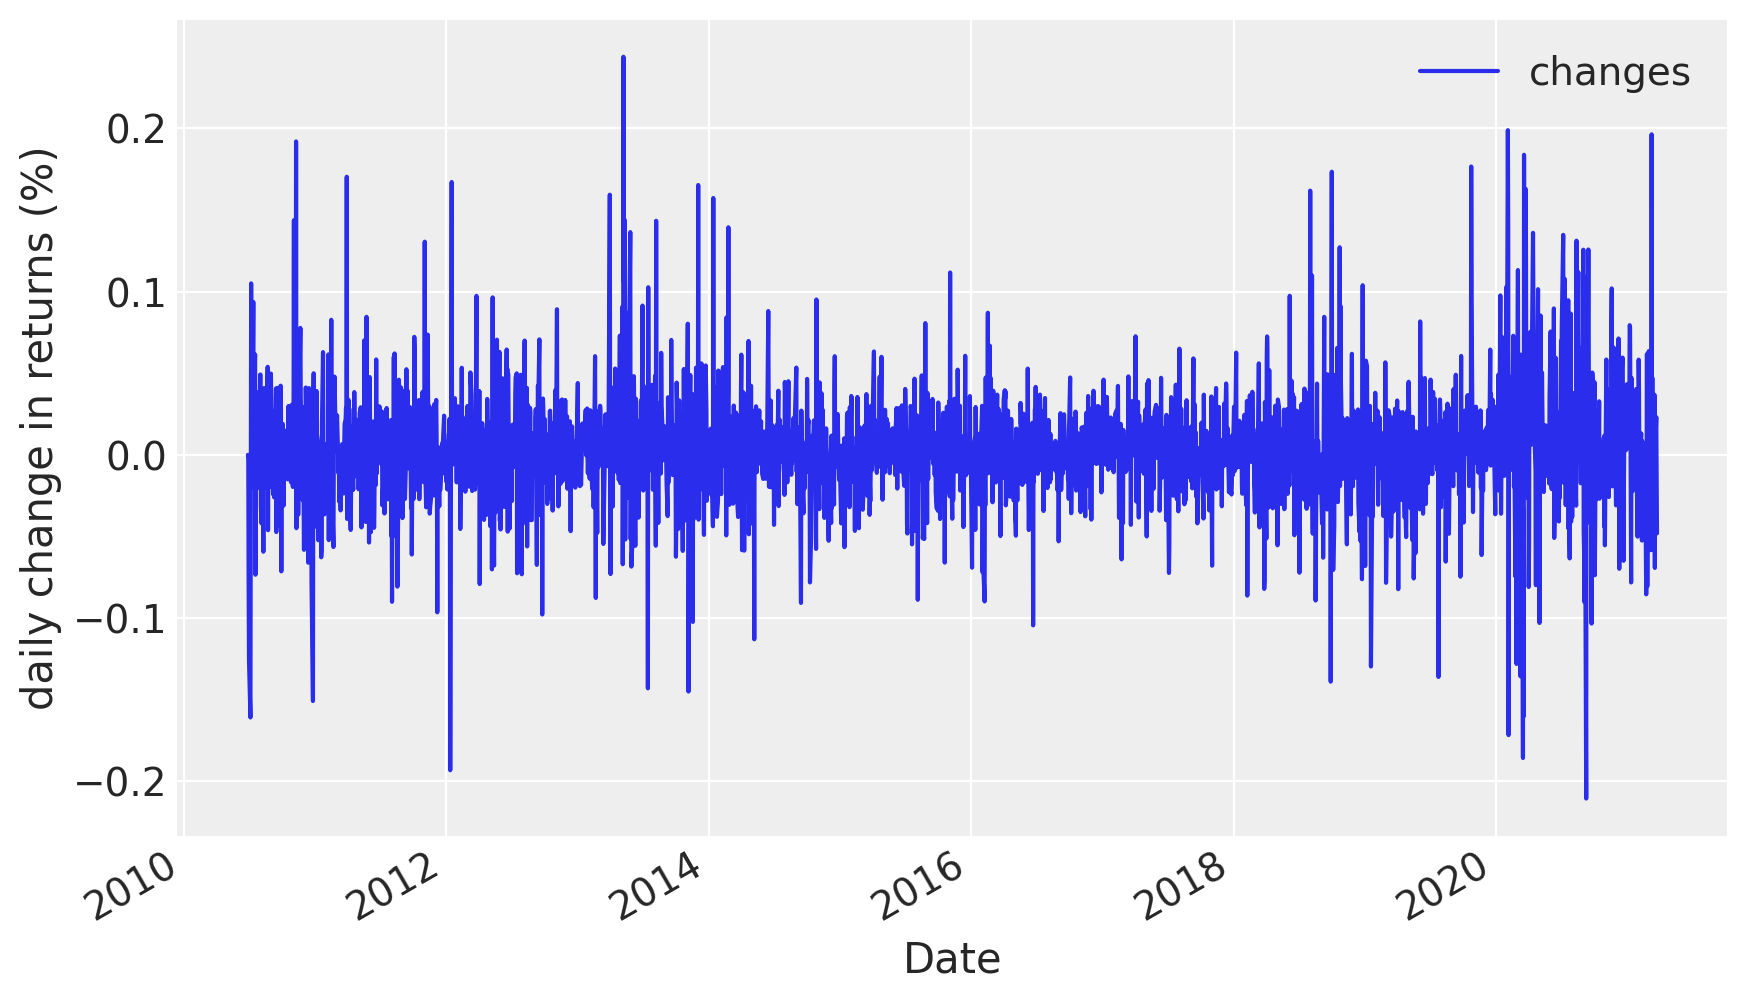

In [81]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    changes.plot(figsize=(10, 6))
    plt.ylabel("daily change in returns (%)");

### Model Specification

As with the linear regression example, specifying the model in PyMC3 mirrors its statistical specification. 

This model employs several new distributions: the Exponential distribution for the 𝜈 and 𝜎 priors, the Student-T (StudentT) distribution for distribution of returns, and the GaussianRandomWalk for the prior for the latent volatilities.

In PyMC3, variables with purely positive priors like Exponential are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named “variableName_log”) is added to the model for sampling. In this model this happens behind the scenes for both the degrees of freedom, nu, and the scale parameter for the volatility process, sigma, since they both have exponential priors. Variables with priors that constrain them on two sides, like Beta or Uniform, are also transformed to be unconstrained but with a log odds transform. We can also provide an initial value for any distribution (called a “test value”) using the testval argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are illegal and we want to ensure we select a legal one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden.

The vector of latent volatilities s is given a prior distribution by GaussianRandomWalk. As its name suggests GaussianRandomWalk is a vector valued distribution where the values of the vector form a random normal walk of length n, as specified by the shape argument. The scale of the innovations of the random walk, sigma, is specified in terms of the standard deviation of the normally distributed innovations and can be a scalar or vector.

In [113]:
with pm.Model() as TSLA_model:
    # The model remembers the datetime index with the name 'date'
    change_returns = pm.Data("changes", changes["changes"], dims="Date", export_index_as_coords=True)

    nu = pm.Exponential("nu", 100, testval=5.0)
    #nu = pm.Normal("nu", mu=2, sigma=4)
    
    sigma = pm.Exponential("sigma", 2, testval=0.1)
    #sigma = pm.Normal("sigma", mu=2, sigma=4)

    # We can now figure out the shape of variables based on the
    # index of the dataset
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="Date")
    # instead of:
    # s = pm.GaussianRandomWalk('s', sigma, shape=len(returns))
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="Date"
    )

    r = pm.StudentT("r", nu=nu, sigma=volatility_process, observed=change_returns, dims="Date")

In [114]:
TSLA_model.RV_dims

{'changes': ('Date',),
 's': ('Date',),
 'volatility_process': ('Date',),
 'r': ('Date',)}

In [115]:
TSLA_model.coords

{'Date': DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
                '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
                '2010-07-12', '2010-07-13',
                ...
                '2021-03-11', '2021-03-12', '2021-03-15', '2021-03-16',
                '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-22',
                '2021-03-23', '2021-03-24'],
               dtype='datetime64[ns]', name='Date', length=2703, freq=None)}

Notice that we transform the log volatility process s into the volatility process by exp(-2*s). Here, exp is a Theano function, rather than the corresponding function in NumPy; Theano provides a large subset of the mathematical functions that NumPy does.

Also note that we have declared the Model name sp500_model in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

### Fitting the model: posterior estimation

In [116]:
with TSLA_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 873 seconds.


0, dim: Date, 2703 =? 2703


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: Date, 2703 =? 2703
0, dim: Date, 2703 =? 2703


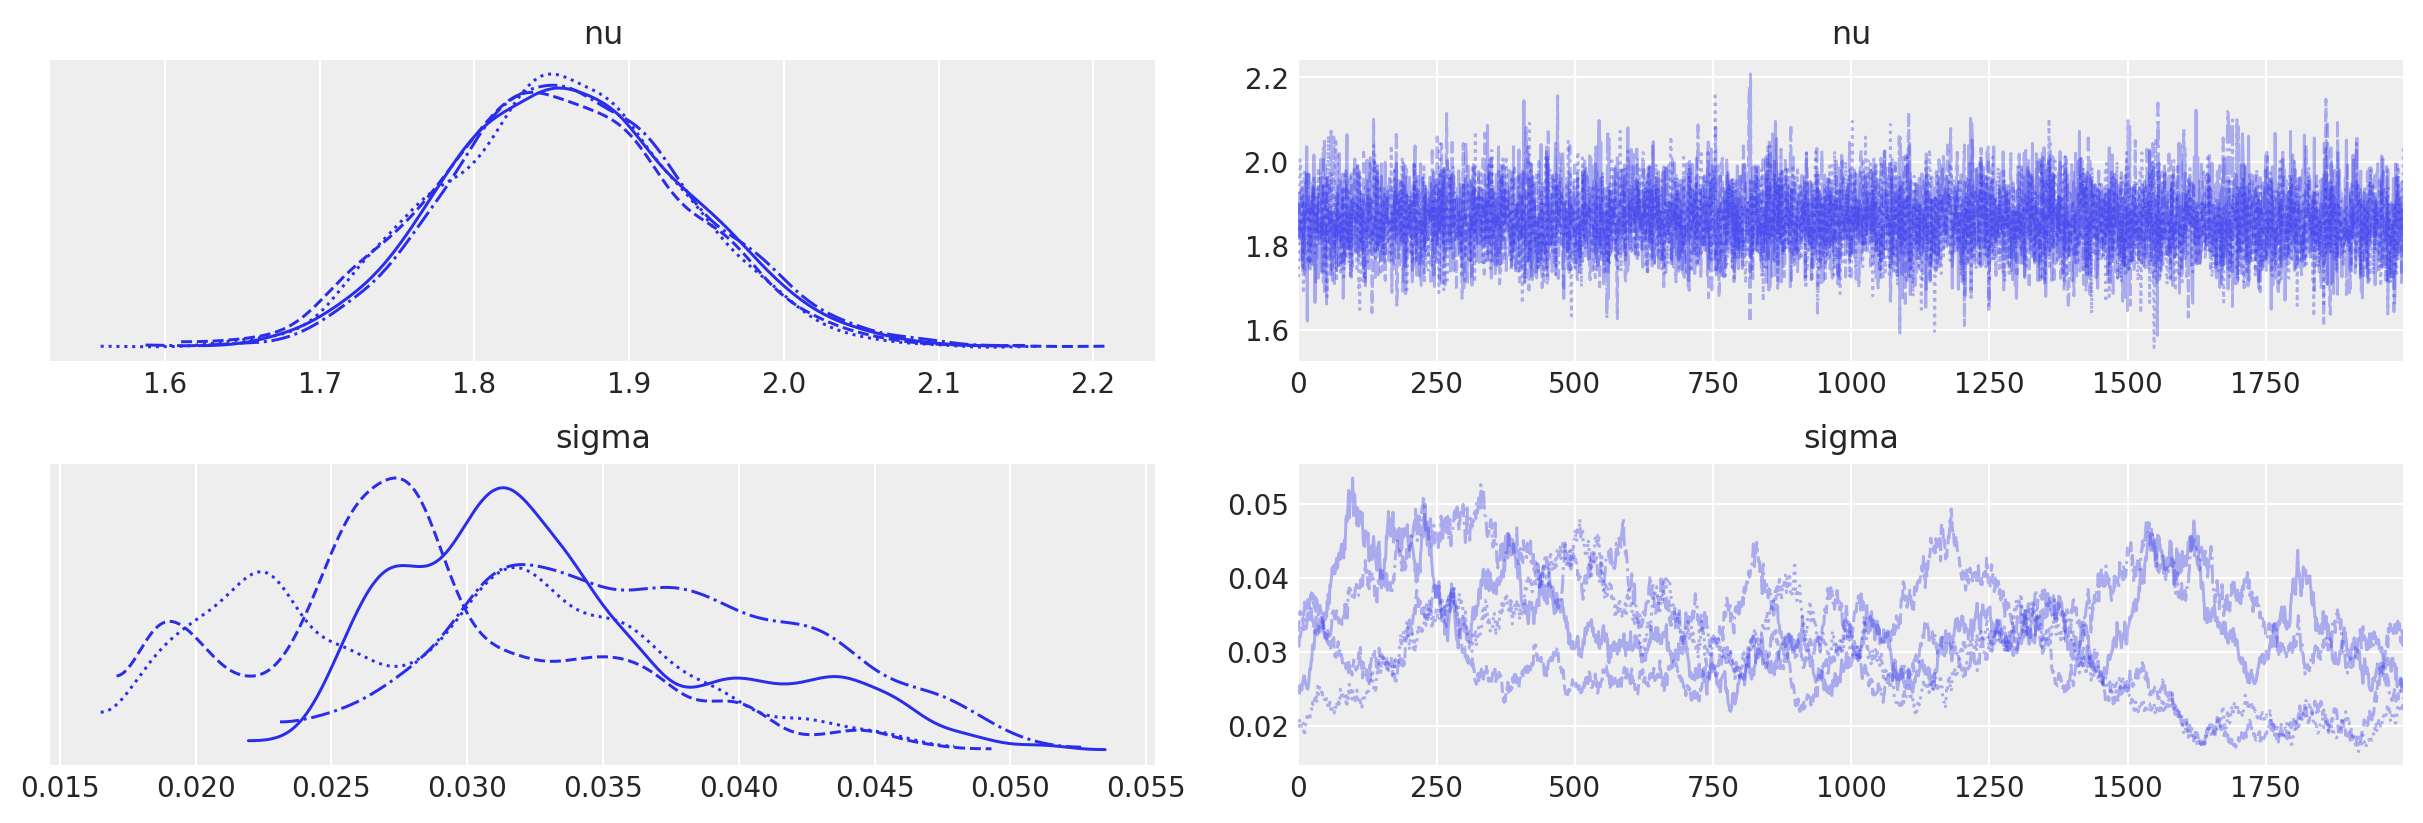

In [117]:
with TSLA_model:
    az.plot_trace(trace, var_names=["nu", "sigma"]);

Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph.

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(bottom=0.2)


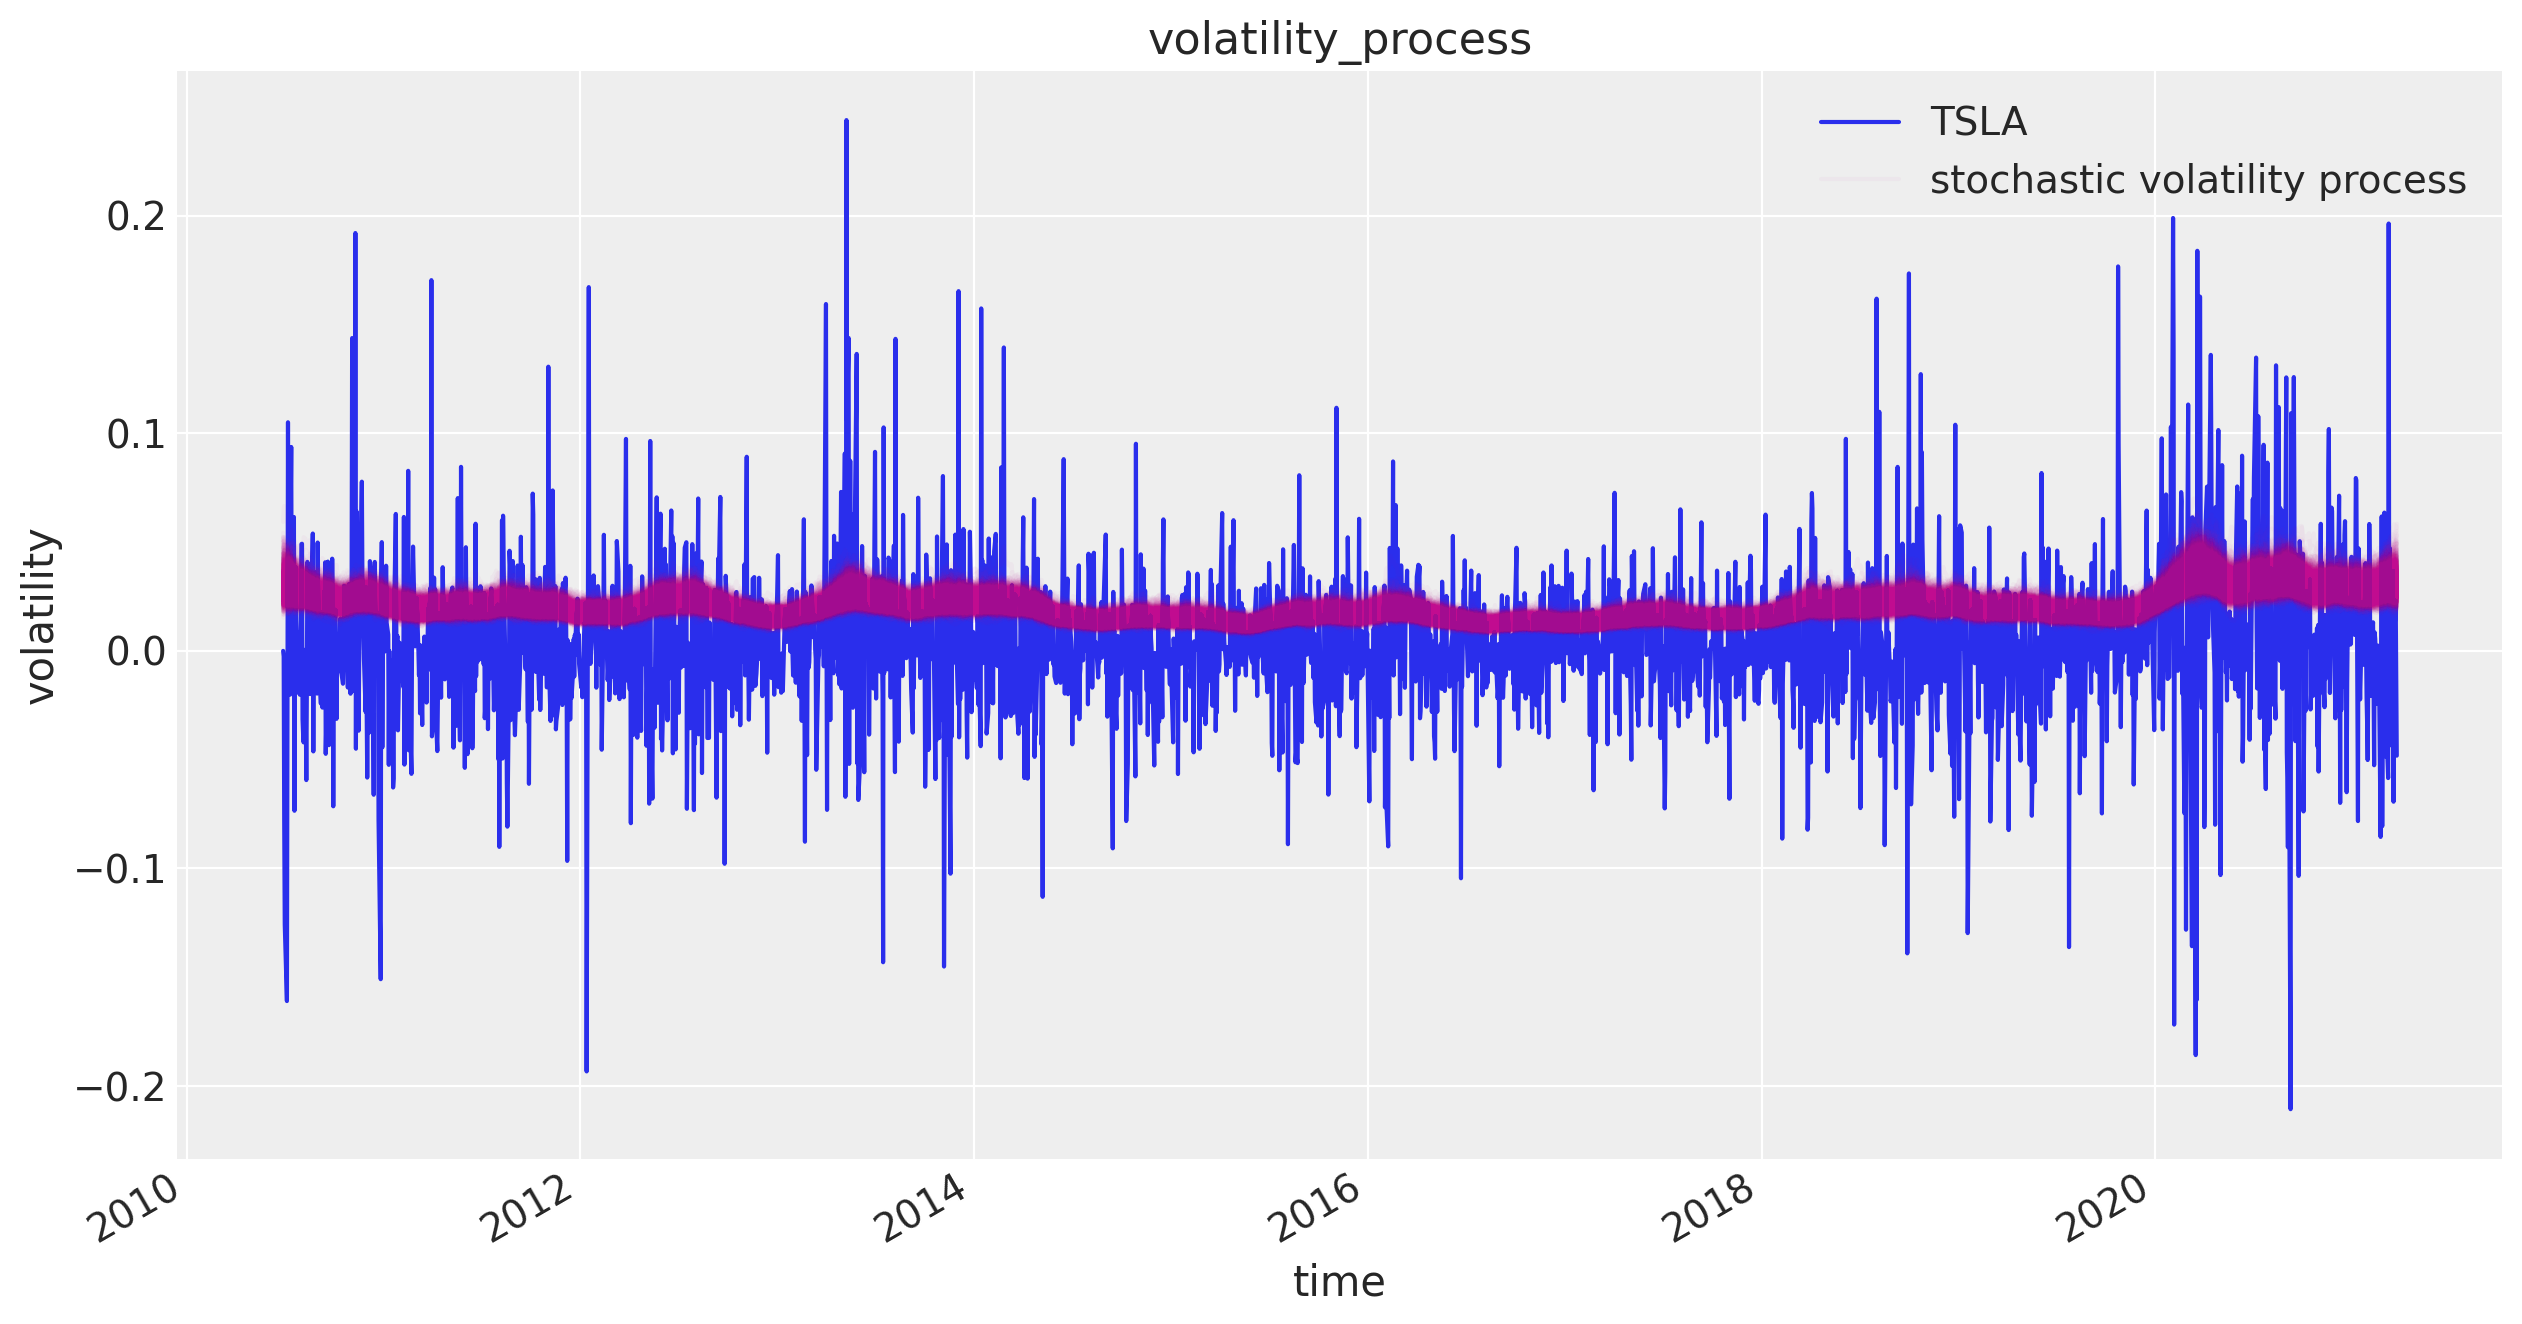

In [118]:
fig, ax = plt.subplots(figsize=(15, 8))
changes.plot(ax=ax)
ax.plot(changes.index, 1 / np.exp(trace["s", ::5].T), "C3", alpha=0.03)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["TSLA", "stochastic volatility process"], loc="upper right");

As you can see, the model correctly infers the increase in volatility during the 2020 COVID crysis. Moreover, note that this model is quite complex because of its high dimensionality and dependency-structure in the random walk distribution. NUTS as implemented in PyMC3, however, correctly infers the posterior distribution with ease.